In [31]:
!nvidia-smi

Fri Apr  1 13:38:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.65       Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8    18W / 290W |   3387MiB /  8192MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
from utils_in.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch
import numpy as np
import os
import psycopg2 as pg
import pandas as pd

In [34]:
use_db = True
resample = '1T'
agg = {'open': 'first',
        'high': 'max', 
        'low': 'min', 
        'close': 'last',
        'volume': 'sum'}
# use db instead of csv
if use_db:
        conn = pg.connect(database='stonksdb', user='postgres', password='stonk')
        # df format [date, features*, *target features]
        query = 'SELECT time AS date, open, high, low, volume, close \
                        FROM stock WHERE identifier = 15521 \
                        ORDER BY time ASC;'
        df = pd.read_sql(query, conn)
        df.set_index(pd.DatetimeIndex(df['date']), inplace=True)
        # resample 
        df = df.resample(resample).agg(agg).dropna()
        df.reset_index(inplace=True)
else:
        agg['trade_count'] = 'sum'
        agg['vwap'] = 'mean'
        df = pd.read_csv('data/AAPL.csv')
        df.set_index(pd.DatetimeIndex(df['timestamp']), inplace=True)
        df.drop(['timestamp'], axis=1, inplace=True)
        df.index.set_names(['date'], inplace=True)
        # resample
        df = df.resample(resample).agg(agg).dropna()
        # df.reset_index(inplace=True)  
        df.to_csv('data/AAPL_h.csv')
df.head()

,date,open,high,low,close,volume
0,2020-03-04 10:14:00,108.20,108.20,108.20,108.20,1439.0
1,2020-03-04 10:15:00,108.25,108.30,108.25,108.30,480.0
2,2020-03-04 10:16:00,108.30,108.30,108.30,108.30,2220.0
3,2020-03-04 10:17:00,108.35,108.35,108.25,108.25,1826.0
4,2020-03-04 10:18:00,108.20,108.20,108.15,108.20,3062.0


In [85]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path = 'data' # root path of data file
args.data_path = 'AAPL_h.csv' # 'dbank_h.csv' # data file

args.use_df = use_db # use dataframe
args.df = df # dataframe

args.features = 'MS' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'close' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints



args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 30 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 5 # encoder input size # ohlc + volume + [trade_count, vwap]
args.dec_in = 5 # decoder input size # ohlc + volume + [trade_count, vwap]
args.c_out = 1 # output size # 1 univariate prediction for close price
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'
args.detail_freq = args.freq
args.inverse = False

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 10
args.patience = 100
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [86]:
Exp = Exp_Informer

In [56]:
from utils.eval_tools import stock_id_to_df
stocks_meta = pd.read_sql('SELECT dataset.identifier AS id, dataset.description AS name \
                            FROM dataset \
                            WHERE identifier = 15521 \
                            ORDER BY dataset.identifier ASC \
                            LIMIT 100;', conn)
# stocks_meta = pd.read_sql('SELECT dataset.identifier AS id, dataset.description AS name \
#              FROM dataset ORDER BY dataset.identifier ASC \
#              LIMIT 100;', conn)
stocks_meta

,id,name
0,15521,Danske Bank A/S


In [87]:
for ii in range(args.itr):
    # set experiments
    exp = Exp(args)
    
    for stock in stocks_meta.itertuples():
        args.df = stock_id_to_df(stock.id, conn, agg, '1T')
        # args.df = args.df[len(args.df)//2:]

        print('>>>>> Training on {}: {}'.format(stock.id, stock.name))
        
        # setting record of experiments
        setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                    args.seq_len, args.label_len, args.pred_len,
                    args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)
        
        # train
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        exp.train(setting)
        
        # test
        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting)

        torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>> Training on 15521: Danske Bank A/S
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl30_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 153425
val 21908
test 43842
	iters: 100, epoch: 1 | loss: 0.0233566
	speed: 0.0411s/iter; left time: 1966.6043s
	iters: 200, epoch: 1 | loss: 0.0130935
	speed: 0.0387s/iter; left time: 1847.8059s
	iters: 300, epoch: 1 | loss: 0.0138312
	speed: 0.0376s/iter; left time: 1793.3320s
	iters: 400, epoch: 1 | loss: 0.0065587
	speed: 0.0375s/iter; left time: 1782.0263s
	iters: 500, epoch: 1 | loss: 0.0080657
	speed: 0.0375s/iter; left time: 1780.1013s
	iters: 600, epoch: 1 | loss: 0.0077091
	speed: 0.0377s/iter; left time: 1784.8082s
	iters: 700, epoch: 1 | loss: 0.0132078
	speed: 0.0379s/iter; left time: 1788.9840s
	iters: 800, epoch: 1 | loss: 0.0109239
	speed: 0.0371s/iter; left time: 1748.3732s
	iters: 900, epoch: 1 | loss: 0.0067862
	speed: 0.0378s/iter; left time: 1779.2714s
	it

In [88]:
setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, 0)
preds = np.load(os.path.join('results', setting, 'pred.npy'))
trues = np.load(os.path.join('results', setting, 'true.npy'))
preds.shape, trues.shape

((43840, 30, 1), (43840, 30, 1))

In [89]:
from data.data_loader import Dataset_Custom
test_data = Dataset_Custom(args.root_path, flag='test', size=[args.seq_len, args.label_len, args.pred_len],
                 features=args.features, data_path=args.data_path, 
                 target=args.target, scale=True, inverse=False, timeenc=0, freq=args.freq, cols=None,
                 use_df=args.use_df, df=args.df)
len(test_data)

43842

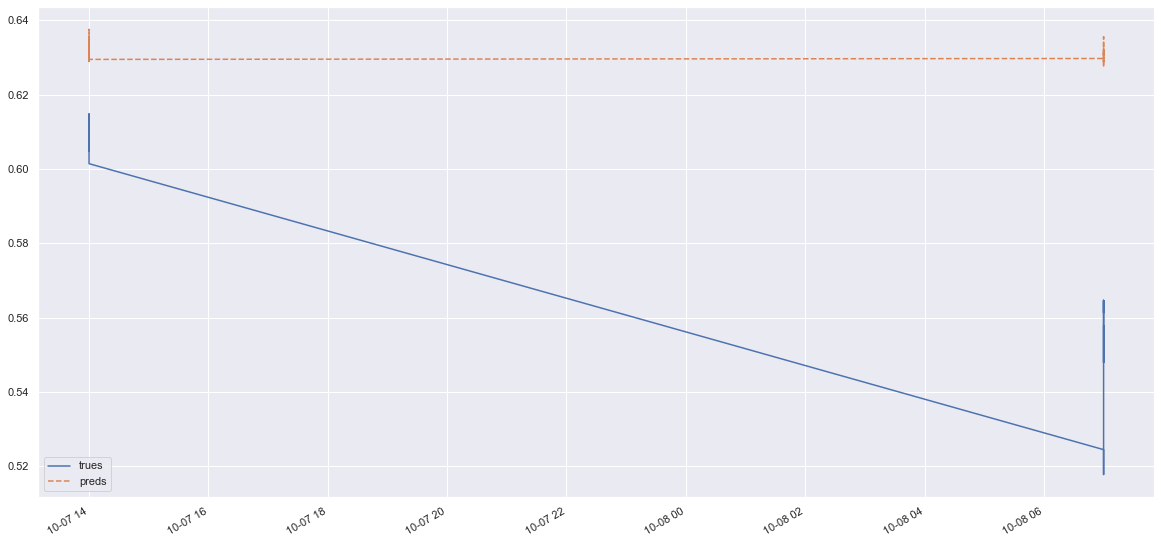

In [90]:
from utils.eval_tools import plot_preds_with_date
idx = 100 
plot_preds_with_date(trues[idx], preds[idx], test_data, idx, figsize=(20,10), style=['-', '--'])

In [91]:
import matplotlib.pyplot as plt

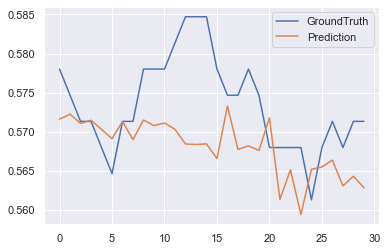

In [94]:
idx = 300
plt.figure()
plt.plot(trues[idx], label='GroundTruth')
plt.plot(preds[idx], label='Prediction')
plt.legend()
plt.show()

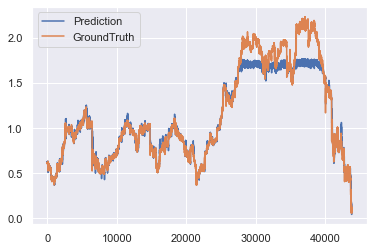

In [95]:
end = len(preds) // preds.shape[1] * preds.shape[1]
preds_first = []
trues_first = []
for i in range(0, end, args.pred_len):
    preds_first.extend(preds[i:i+args.pred_len].squeeze(-1)[np.eye(args.pred_len, dtype=bool)])
    trues_first.extend(trues[i:i+args.pred_len].squeeze(-1)[np.eye(args.pred_len, dtype=bool)])
plt.plot(preds_first, label='Prediction')
plt.plot(trues_first, label='GroundTruth')
plt.legend()
plt.show()

In [96]:
# metrics on test set
mae, mse, rmse, mape, mspe = np.load(f'results/{setting}/metrics.npy')
print('mae: {}, mse: {}, rmse: {}, mape: {}, mspe: {}'.format(mae, mse, rmse, mape, mspe))

mae: 0.06927888095378876, mse: 0.016167106106877327, rmse: 0.12714993953704834, mape: 0.04644287750124931, mspe: 0.005733891855925322


In [97]:
from utils.eval_tools import predict_and_metrics, plot_sample

In [98]:
# load checkpointed model
# create model 
stock_idx = 0
exp = Exp_Informer(args)
args.df = stock_id_to_df(stocks_meta.id[stock_idx], conn, agg, '1h')
print(f'Stock name: {stocks_meta.name[stock_idx]}')
# load weights
best_model_path = 'informer_checkpoints/'+setting+'/'+'checkpoint.pth'
exp.model.load_state_dict(torch.load(best_model_path))

Use GPU: cuda:0
Stock name: Danske Bank A/S


<All keys matched successfully>

In [99]:
tr_preds, te_preds, tr_metrics = predict_and_metrics(exp.model, exp, 'train')
print(f'Train metrics\n mae: {tr_metrics[0]}, mse: {tr_metrics[1]}, \
        rmse: {tr_metrics[2]}, mape: {tr_metrics[3]}, mspe: {tr_metrics[4]}')

train 2681
test shape: (83, 32, 30, 1) (83, 32, 30, 1)
test shape: (2656, 30, 1) (2656, 30, 1)
Train metrics
 mae: 0.1425226330757141, mse: 0.038244981318712234,         rmse: 0.19556324183940887, mape: 1.0075430870056152, mspe: 419.4125671386719


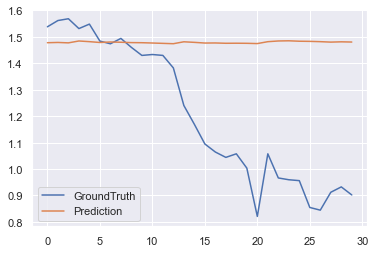

In [107]:
idx = 70
plt.plot(te_preds[idx], label='GroundTruth')
plt.plot(tr_preds[idx], label='Prediction')
plt.legend()
plt.show()

test 772


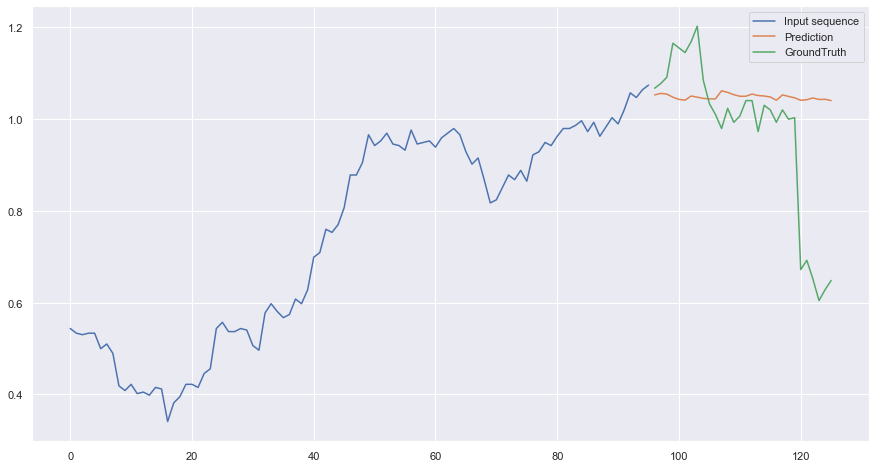

In [114]:
plot_sample(exp, 'test', idx=70, dates=False, figsize=(15,8))

test 772
test 772


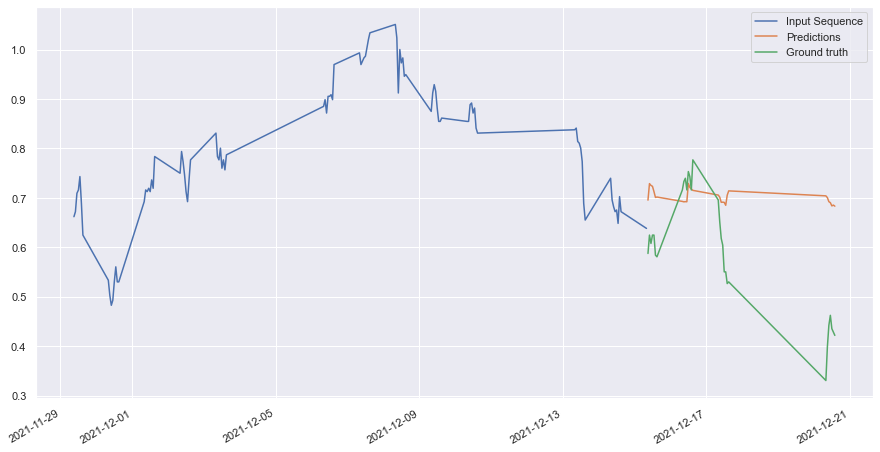

In [117]:
plot_sample(exp, 'test', idx=359, dates=True, figsize=(15,8))